In [1]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve
from numpy import argmax

kmf = KaplanMeierFitter()

# bootstrap_status = {
#             'genomic': [],
#             'clinical': [],
#             'index': [],
#             'project_id': [],
#             'output': [],
#             'target': [],
#             'survival_time': [],
#             'vital_status': []
#         }

# need to save predictions from model
#load npz file

multi_path = '/home/zow/Multi-Cancer/Logs/Trainer/tcga_multi_dnn_trainer_cross_validation_4_bootstrap_test/20231031131546/tcga-brca_tcga-luad_tcga-coad_bootstrap_status.npz'


In [22]:
#check files in npz
multinpzfile = np.load(multi_path)
print(multinpzfile.files)
print(multinpzfile['survival_time'].shape)

['genomic', 'clinical', 'index', 'project_id', 'output', 'target', 'survival_time', 'vital_status']
(1000, 412)


In [31]:
project_ids = multinpzfile['project_id'][1]
project_ids

array([1, 0, 2, 2, 0, 0, 1, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 2, 1,
       0, 0, 0, 0, 1, 2, 0, 2, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 2,
       0, 2, 2, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 0, 2, 1, 1, 2, 2,
       2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 1, 0,
       0, 2, 2, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 2, 1, 0, 1, 2, 1,
       2, 0, 1, 0, 0, 0, 1, 0, 2, 1, 1, 1, 1, 1, 0, 2, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 1, 0, 2,
       1, 1, 2, 1, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 1, 0, 2, 0, 1, 0,
       2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0, 0, 2, 2, 1, 0, 0, 0, 0, 2,
       1, 0, 0, 2, 2, 1, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 1, 2, 2, 0,
       1, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 2, 0, 0, 2, 0, 1, 0, 2, 1, 1, 0, 0, 0, 0, 1, 2, 0,
       2, 1, 0, 1, 0, 1, 0, 2, 1, 0, 0, 0, 0, 1, 1,

In [32]:
# plot how many of each project_id
unique, counts = np.unique(project_ids, return_counts=True)
print(np.asarray((unique, counts)).T)


[[  0 226]
 [  1 104]
 [  2  82]]


In [38]:
# create df with counts for each project_id in each of the 1000 bootstrap samples
def count_project_ids(multinpzfile):
    bootstraps = np.linspace(0, 999, 1000, dtype=int)
    project_id_counts = pd.DataFrame({'bootstrap_index': bootstraps})

    # for each bootstrap sample, count the number of samples for each project_id
    for i in range(1000):
        project_ids_per_bt = multinpzfile['project_id'][i]
        unique, counts = np.unique(project_ids, return_counts=True)   
        
        project_id_counts['BRCA'] = counts[0]
        project_id_counts['COAD'] = counts[1]
        project_id_counts['LUAD'] = counts[2]

    return project_id_counts




In [34]:
project_id_counts.head()

,project_id,counts
0,1,104
1,0,226
2,2,82
3,2,82
4,0,226


In [4]:

def youden_j(output, target):

    y_score = output
    y_true = target

    fpr, tpr, thresholds = roc_curve(y_true, y_score)

    return thresholds[argmax(tpr - fpr)]

In [5]:
def get_threshold(output, target):
    if output.ndim == 2:
        if output.shape[-1] == 2:
            output = output[:, 1]
            threshold = youden_j(output, target)
            #y_score = (output > threshold).astype('int64')
        else:
            #y_score = np.argmax(output, dim=1)
            threshold = youden_j(output, target)
    else:
        threshold = youden_j(output, target)
        #y_score = (output > threshold).astype('int64')

    return threshold

In [54]:
def plot_survival_curves_multi(npz_data, cancer_type, model):

    output = npz_data['output']
    target = npz_data['target']
    survival_time = npz_data['survival_time']
    vital_status = npz_data['vital_status']
    project_id = npz_data['project_id']

    #concatenate each list in the array
    output = np.concatenate(output, axis=0)
    target = np.concatenate(target, axis=0)
    survival_time = np.concatenate(survival_time, axis=0)
    vital_status = np.concatenate(vital_status, axis=0)
    project_id = np.concatenate(project_id, axis=0)

    #get project id counts
    project_id_counts = count_project_ids(npz_data)

    # Create a DataFrame (assuming all arrays have the same length)
    data = pd.DataFrame({
        'output': output.tolist(),
        'target': target.tolist(),
        'survival_time': survival_time.tolist(),
        'vital_status': vital_status.tolist(),
        'project_id': project_id.tolist()
    })

    if cancer_type == 'COAD':
        data['survival_time'] = pd.to_numeric(data['survival_time'], errors='coerce')
        data['vital_status'] = pd.to_numeric(data['vital_status'], errors='coerce')

    # survival time is currently in days, convert to years
    data['survival_time'] = data['survival_time'] / 365.25

    # separate data into 3 dataframes based on project ID
    if cancer_type == 'BRCA':

        data= data[data['project_id'] == 0]
        id_counts = project_id_counts['BRCA']
        n_bootstrap_samples  = 969
    elif cancer_type == 'LUAD':
        data = data[data['project_id'] == 1]
        id_counts = project_id_counts['LUAD']
        n_bootstrap_samples  = 1000
    elif cancer_type == 'COAD':
        data = data[data['project_id'] == 2]
        id_counts = project_id_counts['COAD']
        n_bootstrap_samples  = 877


    n_records = len(data['survival_time'])

    # Initialize empty lists to store survival probabilities
    all_survival_probabilities_good = []
    all_survival_probabilities_bad = []
    logrank_p_values = []

    # Initialize KaplanMeierFitter instances
    kmf_good = KaplanMeierFitter()
    kmf_bad = KaplanMeierFitter()

    time_points = np.linspace(0, 5, 500) # 500 time points between 0 and 5 years

    # Loop over each bootstrap sample
    for i in range(n_bootstrap_samples): # should be 1000
        # Slice the DataFrame to get the records for this bootstrap sample
        n_records = id_counts[i]
        if i == 0:
            bootstrap_sample = data.iloc[0 : n_records]
        else:
            bootstrap_sample = data.iloc[sum(id_counts[0:i]) : sum(id_counts[0:i]) + n_records]
        
        # Segment the records into risk groups based on the 'output' field
        try:
            threshold = get_threshold(bootstrap_sample['output'], bootstrap_sample['target'])
        except ValueError:
            print('ValueError')
            print('Index ' + str(i))
            continue
        
        good_prognosis = bootstrap_sample[bootstrap_sample['output'] >= threshold]
        bad_prognosis = bootstrap_sample[bootstrap_sample['output'] < threshold]
        #sometime a bootstrap sample will have all good or all bad prognosis, so we need to check for that
        
        # Fit and interpolate for good prognosis
        if not good_prognosis.empty:
            kmf_good.fit(good_prognosis['survival_time'], event_observed=good_prognosis['vital_status'])
            interpolated_good = np.interp(time_points, kmf_good.survival_function_.index, kmf_good.survival_function_['KM_estimate'])
            all_survival_probabilities_good.append(interpolated_good)
        
        # Fit and interpolate for bad prognosis
        if not good_prognosis.empty and not bad_prognosis.empty:
            kmf_bad.fit(bad_prognosis['survival_time'], event_observed=bad_prognosis['vital_status'])
            interpolated_bad = np.interp(time_points, kmf_bad.survival_function_.index, kmf_bad.survival_function_['KM_estimate'])
            all_survival_probabilities_bad.append(interpolated_bad)
        # Perform log-rank test
        if good_prognosis['vital_status'].sum() > 0 and bad_prognosis['vital_status'].sum() > 0:
            results = logrank_test(good_prognosis['survival_time'], bad_prognosis['survival_time'], 
                                   event_observed_A=good_prognosis['vital_status'], event_observed_B=bad_prognosis['vital_status'])
            logrank_p_values.append(results.p_value)



    # Convert to NumPy arrays
    all_survival_probabilities_good = np.array(all_survival_probabilities_good)
    all_survival_probabilities_bad = np.array(all_survival_probabilities_bad)

    # Calculate average and confidence intervals
    average_good = np.mean(all_survival_probabilities_good, axis=0)
    average_bad = np.mean(all_survival_probabilities_bad, axis=0)

    ci_lower_good = np.percentile(all_survival_probabilities_good, 2.5, axis=0)
    ci_upper_good = np.percentile(all_survival_probabilities_good, 97.5, axis=0)

    ci_lower_bad = np.percentile(all_survival_probabilities_bad, 2.5, axis=0)
    ci_upper_bad = np.percentile(all_survival_probabilities_bad, 97.5, axis=0)

    # Average log-rank test p-value
    # Filter out NaNs and calculate the average p-value
    logrank_p_values = np.array(logrank_p_values)
    logrank_p_values = logrank_p_values[~np.isnan(logrank_p_values)]

    if logrank_p_values.size > 0:
        average_logrank_p_value = np.mean(logrank_p_values)
    else:
        average_logrank_p_value = "Undefined"

    print(f'Average log-rank test p-value: {average_logrank_p_value:.10f}')

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(time_points, average_bad, label='Low Risk Group')
    plt.fill_between(time_points, ci_lower_bad, ci_upper_bad, alpha=0.5)

    plt.plot(time_points, average_good, label='High Risk Group')
    plt.fill_between(time_points, ci_lower_good, ci_upper_good, alpha=0.5)



    plt.xlim(0, 5)

    plt.title(f'Avg KM Survival Curve Across 1000 Bootstraps - {model} - {cancer_type} \nAverage Log-rank Test p-value: {average_logrank_p_value:.6f}')
    plt.xlabel('Time (in years)')
    plt.ylabel('Survival Probability')
    plt.legend()
    plt.savefig(f'km_{cancer_type}_{model}.pdf')
    plt.show()

Average log-rank test p-value: 0.0000146846


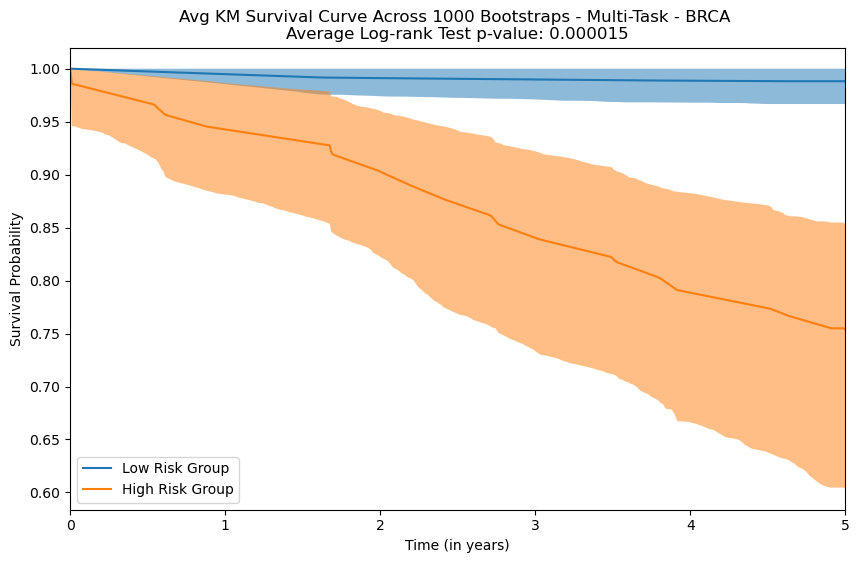

In [55]:
plot_survival_curves_multi(multinpzfile, 'BRCA', 'Multi-Task')

Average log-rank test p-value: 0.0280


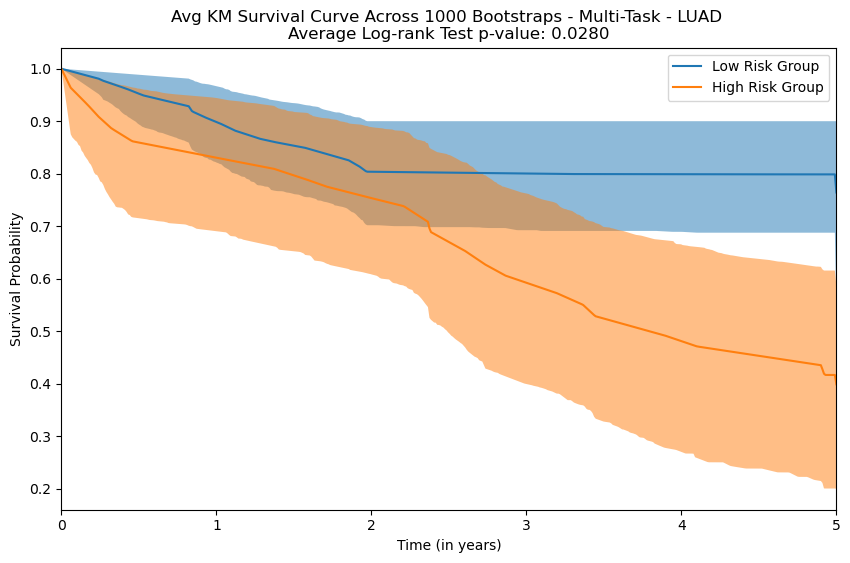

In [47]:
plot_survival_curves_multi(multinpzfile, 'LUAD', 'Multi-Task')

Average log-rank test p-value: 0.0052


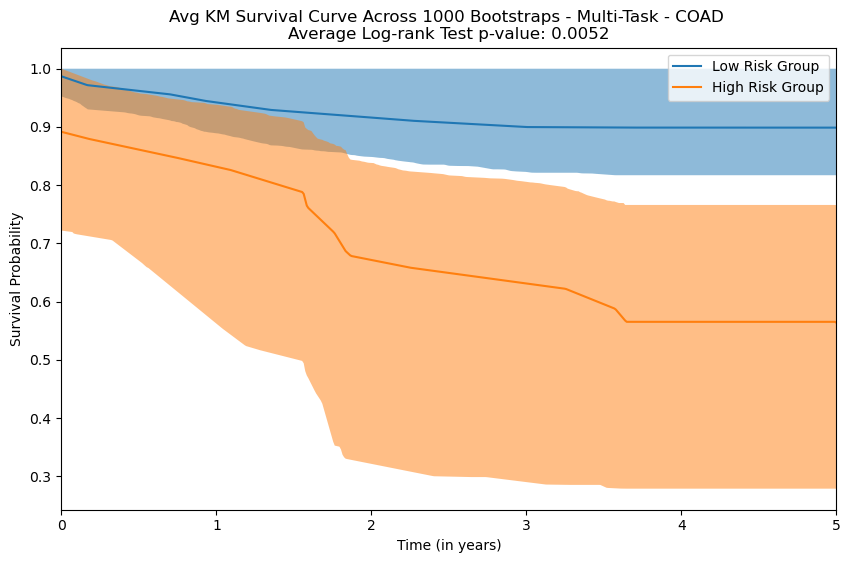

In [51]:
plot_survival_curves_multi(multinpzfile, 'COAD', 'Multi-Task')

In [16]:

def plot_survival_curves_single(npz_data, cancer_type, model):
    n_records = npz_data['survival_time'].shape[1]
    # Load individual arrays

    output = npz_data['output']
    target = npz_data['target']
    survival_time = npz_data['survival_time']
    vital_status = npz_data['vital_status']

    #concatenate each list in the array
    output = np.concatenate(output, axis=0)
    target = np.concatenate(target, axis=0)
    survival_time = np.concatenate(survival_time, axis=0)
    vital_status = np.concatenate(vital_status, axis=0)

    # Create a DataFrame (assuming all arrays have the same length)
    data = pd.DataFrame({
        'output': output.tolist(),
        'target': target.tolist(),
        'survival_time': survival_time.tolist(),
        'vital_status': vital_status.tolist()
    })

    if cancer_type == 'COAD':
        data['survival_time'] = pd.to_numeric(data['survival_time'], errors='coerce')
        data['vital_status'] = pd.to_numeric(data['vital_status'], errors='coerce')

    # survival time is currently in days, convert to years
    data['survival_time'] = data['survival_time'] / 365.25


    # Initialize empty lists to store survival probabilities
    all_survival_probabilities_good = []
    all_survival_probabilities_bad = []
    logrank_p_values = []

    # Initialize KaplanMeierFitter instances
    kmf_good = KaplanMeierFitter()
    kmf_bad = KaplanMeierFitter()

    # Assume that each bootstrap sample has `n_records` number of records

    n_bootstrap_samples = int(data.shape[0] / n_records)


    time_points = np.linspace(0, 5, 500) # 500 time points between 0 and 5 years

    # Loop over each bootstrap sample
    for i in range(n_bootstrap_samples):
        # Slice the DataFrame to get the records for this bootstrap sample
        bootstrap_sample = data.iloc[i * n_records : (i + 1) * n_records]
        
        # Segment the records into risk groups based on the 'output' field
        threshold = get_threshold(bootstrap_sample['output'], bootstrap_sample['target'])
        good_prognosis = bootstrap_sample[bootstrap_sample['output'] >= threshold]
        bad_prognosis = bootstrap_sample[bootstrap_sample['output'] < threshold]
        #sometime a bootstrap sample will have all good or all bad prognosis, so we need to check for that
        
        # Fit and interpolate for good prognosis
        if not good_prognosis.empty:
            kmf_good.fit(good_prognosis['survival_time'], event_observed=good_prognosis['vital_status'])
            interpolated_good = np.interp(time_points, kmf_good.survival_function_.index, kmf_good.survival_function_['KM_estimate'])
            all_survival_probabilities_good.append(interpolated_good)
        
        # Fit and interpolate for bad prognosis
        if not good_prognosis.empty and not bad_prognosis.empty:
            kmf_bad.fit(bad_prognosis['survival_time'], event_observed=bad_prognosis['vital_status'])
            interpolated_bad = np.interp(time_points, kmf_bad.survival_function_.index, kmf_bad.survival_function_['KM_estimate'])
            all_survival_probabilities_bad.append(interpolated_bad)
        # Perform log-rank test
        if good_prognosis['vital_status'].sum() > 0 and bad_prognosis['vital_status'].sum() > 0:
            results = logrank_test(good_prognosis['survival_time'], bad_prognosis['survival_time'], 
                                   event_observed_A=good_prognosis['vital_status'], event_observed_B=bad_prognosis['vital_status'])
            logrank_p_values.append(results.p_value)



    # Convert to NumPy arrays
    all_survival_probabilities_good = np.array(all_survival_probabilities_good)
    all_survival_probabilities_bad = np.array(all_survival_probabilities_bad)

    # Calculate average and confidence intervals
    average_good = np.mean(all_survival_probabilities_good, axis=0)
    average_bad = np.mean(all_survival_probabilities_bad, axis=0)

    ci_lower_good = np.percentile(all_survival_probabilities_good, 2.5, axis=0)
    ci_upper_good = np.percentile(all_survival_probabilities_good, 97.5, axis=0)

    ci_lower_bad = np.percentile(all_survival_probabilities_bad, 2.5, axis=0)
    ci_upper_bad = np.percentile(all_survival_probabilities_bad, 97.5, axis=0)

    # Average log-rank test p-value
    # Filter out NaNs and calculate the average p-value
    logrank_p_values = np.array(logrank_p_values)
    logrank_p_values = logrank_p_values[~np.isnan(logrank_p_values)]

    if logrank_p_values.size > 0:
        average_logrank_p_value = np.mean(logrank_p_values)
    else:
        average_logrank_p_value = "Undefined"

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(time_points, average_bad, label='Low Risk Group')
    plt.fill_between(time_points, ci_lower_bad, ci_upper_bad, alpha=0.5)

    plt.plot(time_points, average_good, label='High Risk Group')
    plt.fill_between(time_points, ci_lower_good, ci_upper_good, alpha=0.5)



    plt.xlim(0, 5)

    plt.title(f'Avg KM Survival Curve Across 1000 Bootstraps - {model} - {cancer_type} \nAverage Log-rank Test p-value: {average_logrank_p_value:.4f}')
    plt.xlabel('Time (in years)')
    plt.ylabel('Survival Probability')
    plt.legend()
    plt.savefig(f'km_{cancer_type}_{model}.pdf')
    plt.show()


In [17]:
# get km survival curves for each cancer type using single task mode

single_brca = np.load('/home/zow/Multi-Cancer/Logs/Trainer/tcga_dnn_trainer_cross_validation_4_bootstrap_test/20231101160629/tcga-brca_bootstrap_status.npz') 
single_luad = np.load('/home/zow/Multi-Cancer/Logs/Trainer/tcga_dnn_trainer_cross_validation_4_bootstrap_test/20231101160629/tcga-luad_bootstrap_status.npz')
single_coad = np.load('/home/zow/Multi-Cancer/Logs/Trainer/tcga_dnn_trainer_cross_validation_4_bootstrap_test/20231101160629/tcga-coad_bootstrap_status.npz')

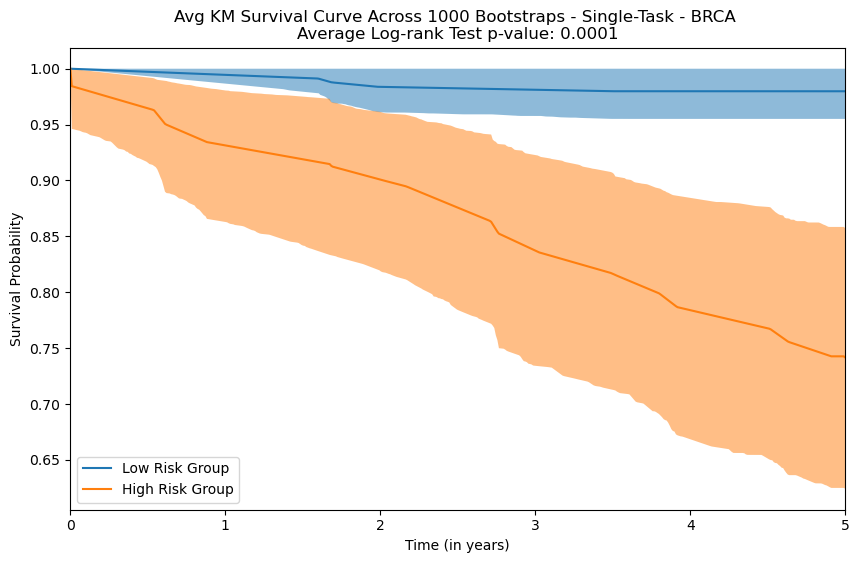

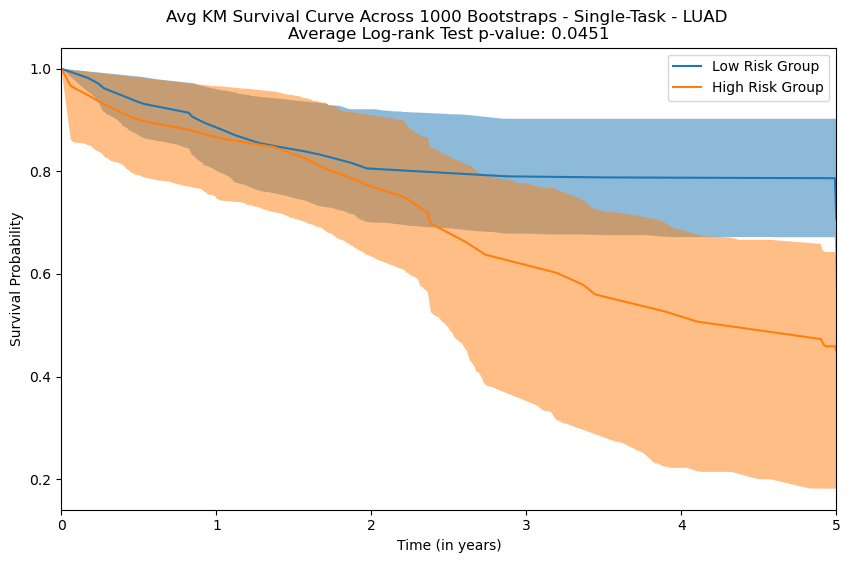

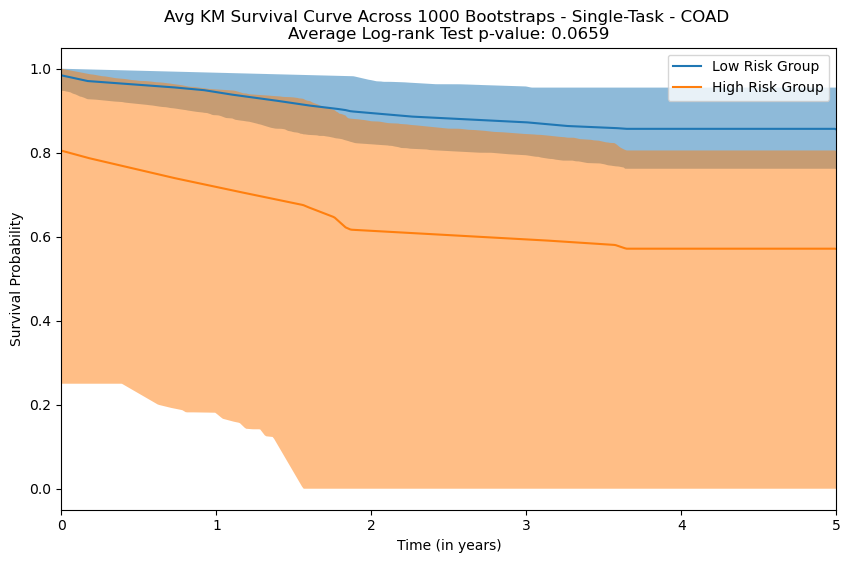

In [18]:
plot_survival_curves_single(single_brca, 'BRCA', 'Single-Task')
plot_survival_curves_single(single_luad, 'LUAD', 'Single-Task')
plot_survival_curves_single(single_coad, 'COAD', 'Single-Task')